In [2]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [3]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [ ]:
mc = ak.from_parquet('/scratch365/cmoore24/training/hgg/ecf_vs_data/inputs/test/mc.parquet')
data = ak.from_parquet('/scratch365/cmoore24/training/hgg/ecf_vs_data/inputs/test/data.parquet')

In [ ]:
mc.fields

In [4]:
path = '/scratch365/cmoore24/training/hgg/ecf_vs_data/outputs/intial_attempt/256/2048/2'

In [5]:
model = f'{path}/traced_model.pt'

In [6]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [7]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler, imap):
        #fatjets = events

        arr_list = [x[:, np.newaxis] for x in imap['vars'].values()]
        new_list = []
        for i in arr_list:
            new_list.append(i.to_numpy())
        retmap = {'vars': ak.from_numpy(np.concatenate(new_list, axis=1))}

        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [8]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [9]:
def imapper(array, ratio_list):
    imap = {}
    imap['vars'] = {}
    for i in ratio_list:
        try:
            imap['vars'][i] = array[i]
        except:
            imap['vars'][i] = array[i]
    return imap

In [10]:
mc_imap = imapper(mc, mc.fields)
mc_scores = tagger(mc, scaler, mc_imap)[:,0]

In [11]:
data_imap = imapper(data, data.fields)
data_scores = tagger(data, scaler, data_imap)[:,0]

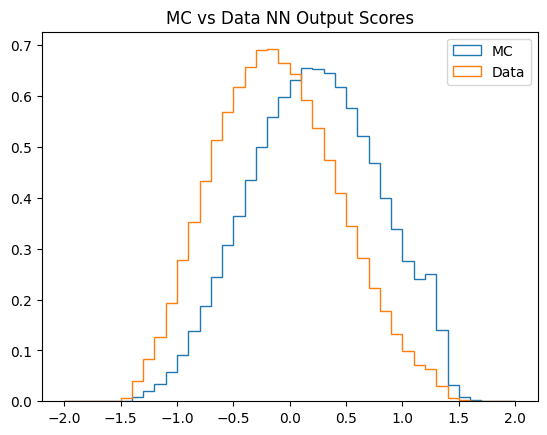

In [12]:
pltrange = (-2, 2)
plt.hist(mc_scores, bins=40, histtype='step', label='MC', density=True, range=pltrange)
plt.hist(data_scores, bins=40, histtype='step', label='Data', density=True, range=pltrange)
plt.title(f'MC vs Data NN Output Scores')
plt.legend()
plt.show()

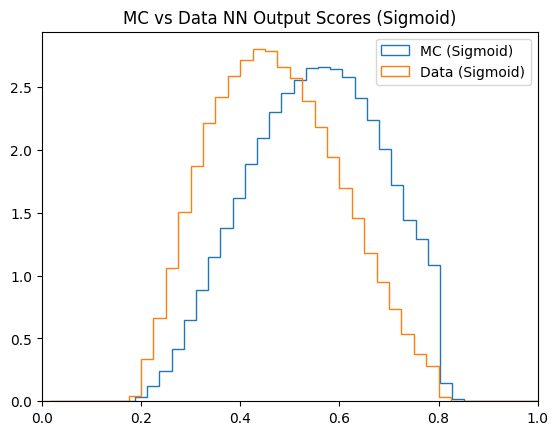

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid to the scores
mc_scores_sigmoid = sigmoid(mc_scores)
data_scores_sigmoid = sigmoid(data_scores)

# Plot the histograms for scores after applying sigmoid
pltrange = (0, 1)  # Adjust the range to match the sigmoid output
plt.hist(mc_scores_sigmoid, bins=40, histtype='step', label='MC (Sigmoid)', density=True)#, range=pltrange)
plt.hist(data_scores_sigmoid, bins=40, histtype='step', label='Data (Sigmoid)', density=True)#, range=pltrange)
plt.title(f'MC vs Data NN Output Scores (Sigmoid)')
plt.legend()
plt.xlim(0,1)
plt.show()

In [ ]:
bins = np.linspace(...)
# mc_scores_sigmoid = math(neuralnetwork(event_ecf_values))
plt.hist(mc_pt, bins=bins, weights=(1-mc_scores_sigmoid)/mc_scores_sigmoid, label="Reweighted to data");
plt.hist(mc_pt, bins=bins, label="Unweighted");

In [14]:
mask = ~np.isnan(data_scores)
data_scores = data_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
data_train = data[mask]

In [15]:
mask = ~np.isnan(mc_scores)
mc_scores = mc_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
mc_train = mc[mask]

In [16]:
bkg_zeros = ak.zeros_like(data_scores_sigmoid)
sig_ones = ak.ones_like(mc_scores_sigmoid)
combined = ak.concatenate([data_scores_sigmoid,mc_scores_sigmoid])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [17]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [18]:
hrange=(np.floor(ak.min(mc_scores_sigmoid)), np.ceil(ak.max(data_scores_sigmoid)))

In [19]:
mc_hist = np.histogram(mc_scores_sigmoid, bins=10,
                range=hrange
                )
data_hist = np.histogram(data_scores_sigmoid, bins=10, 
                 range=hrange
                )

In [20]:
sig_sums = []
for i in range(len(mc_hist[0])+1):
    sig_sums.append(sum(mc_hist[0][len(mc_hist[0])-i:]))

bkg_sums = []
for i in range(len(data_hist[0])+1):
    bkg_sums.append(sum(data_hist[0][len(data_hist[0])-i:]))

In [21]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [22]:
wp_ratios = {}
for i in range(len(mc_hist[1])):
    wp_ratios[str(mc_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

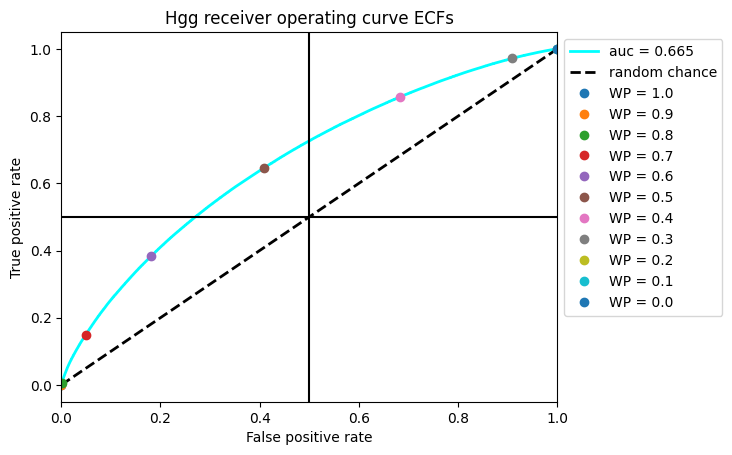

In [23]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.1f}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [24]:
with open('ecf_bdt.json', 'r') as f:
    ecfs = json.load(f)

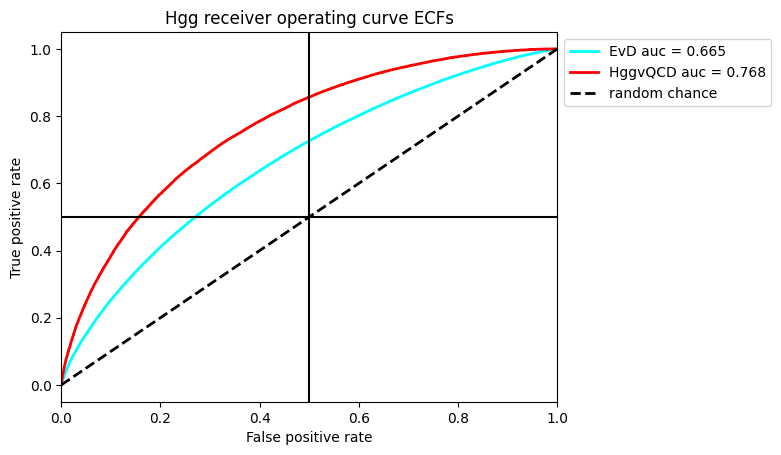

In [30]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="EvD auc = %.3f" % (roc_auc))
plt.plot(ecfs['fpr'], ecfs['tpr'], lw=2, color="red", label="HggvQCD auc = %.3f" % (ecfs['auc']))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.show()